In [10]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import numpy as np

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
3,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
4,pretrained,linear_classification,Transformer,,-1,-1,20,12,8,linear_classification
1,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
0,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
2,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [4]:
# task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"
task = "linear_classification"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

linear_classification pretrained


100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]

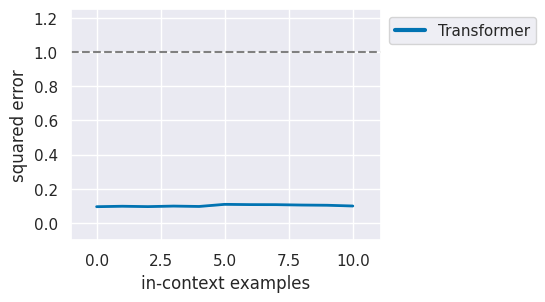

In [8]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

In [36]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [5]:
# from samplers import get_data_sampler
from tasks import get_task_sampler

In [6]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

# data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

### Inference data generation function

In [7]:
def shuffle_within_batch(xs, ys):
    b_size, n_points, _ = xs.shape
    # Generate a random permutation for each batch
    permutations = torch.randperm(n_points).repeat(b_size, 1)

    # Apply the same permutation to each batch in xs and ys
    xs_shuffled = torch.gather(xs, 1, permutations.unsqueeze(-1).expand(-1, -1, xs.size(2)))
    ys_shuffled = torch.gather(ys, 1, permutations)

    return xs_shuffled, ys_shuffled

## generate inference data
def testSample(n_points, b_size, bias1=1, bias2=-1, std=2.0, p1=0.7,p2=0.7,frac_pos=0.5):
    x_bias1 = torch.normal(mean=bias1, std=std, size=(1, n_dims))
    x_bias2 = torch.normal(mean=bias2, std=std, size=(1, n_dims))
    split_index = int(n_points * frac_pos)
    if n_points>0:
        ## first obtain in-context examples
        xs_b = torch.randn(b_size, n_points, n_dims)
        xs_b[:, :split_index, :] += x_bias1
        xs_b[:, split_index:, :] += x_bias2
        
        true_y = torch.empty(b_size, n_points)
        probs_first_half = torch.tensor([p1, 1-p1])  # Probability for 1 and -1 respectively
        choices_first_half = torch.tensor([1, -1])
        if split_index>0:
            first_half = torch.multinomial(probs_first_half, b_size * split_index, replacement=True).reshape(b_size, split_index)
            true_y[:, :split_index] = choices_first_half[first_half]
        probs_second_half = torch.tensor([1-p2, p2])  # Probability for 1 and -1 respectively
        choices_second_half = torch.tensor([1, -1])
        if n_points - split_index>0:
            second_half = torch.multinomial(probs_second_half, b_size * (n_points - split_index), replacement=True).reshape(b_size, n_points - split_index)
            true_y[:, split_index:] = choices_second_half[second_half]
        #shuffle examples
        xs_b, true_y = shuffle_within_batch(xs_b, true_y)
        
        ## add query samples
        split_batch = b_size // 2
        additional_first_half = torch.randn(split_batch, 1, n_dims) 
        additional_first_half += x_bias1
        additional_second_half = torch.randn(b_size - split_batch, 1, n_dims) 
        additional_second_half += x_bias2
        additional_points = torch.cat([additional_first_half, additional_second_half], dim=0)
        xs_b = torch.cat([xs_b, additional_points], dim=1)
        
        additional_first_half = torch.ones((split_batch, 1))
        additional_second_half = -torch.ones((b_size - split_batch, 1))
        additional_labels = torch.cat([additional_first_half, additional_second_half], dim=0)
        true_y = torch.cat([true_y, additional_labels], dim=1)
    
    else:
        #zero-shot, only query samples
        split_batch = b_size // 2
        additional_first_half = torch.randn(split_batch, 1, n_dims) 
        additional_first_half += x_bias1
        additional_second_half = torch.randn(b_size - split_batch, 1, n_dims) 
        additional_second_half += x_bias2
        xs_b = torch.cat([additional_first_half, additional_second_half], dim=0)
        additional_first_half = torch.ones((split_batch, 1))
        additional_second_half = -torch.ones((b_size - split_batch, 1))
        true_y = torch.cat([additional_first_half, additional_second_half], dim=0)
    
    return xs_b, true_y

In [8]:
task = task_sampler()
# xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
# ys = task.generate_true_y(xs)

#### Inference function

In [17]:
def testF(n_points, b_size, bias1, bias2, std, p1, p2, frac_pos, model, rep=100):
    pos_pos_ls = []
    neg_neg_ls = []
    
    for _ in range(rep):
        xs, ys = testSample(n_points, b_size, bias1, bias2, std, p1, p2, frac_pos)
        
        with torch.no_grad():
            pred = model(xs, ys).sign()

        pred_pos = pred[:b_size//2,-1]
        pred_neg = pred[b_size//2:,-1]

        pos_pos = sum(pred_pos==1)/len(pred_pos)
        neg_neg = sum(pred_neg==-1)/len(pred_neg)
        
        pos_pos_ls.append(pos_pos)
        neg_neg_ls.append(neg_neg)
    
    pos_pos_np = np.array(pos_pos_ls)
    neg_neg_np = np.array(neg_neg_ls)
    
    pos_pos_avg = np.mean(pos_pos_np)
    neg_neg_avg = np.mean(neg_neg_np)
    
    pos_pos_std = np.std(pos_pos_np, ddof=1)
    neg_neg_std = np.std(neg_neg_np, ddof=1)
    
    return [pos_pos_avg, neg_neg_avg], [pos_pos_std, neg_neg_std]

### Zero-shot prediction

In [18]:
n_points=0
b_size = 1000
bias1=0.5
bias2=-0.5
std=1.0
p1=1.0
p2=1.0
frac_pos=1.0
# xs, ys = testSample(n_points, b_size, bias1, bias2, std, p1, p2, frac_pos)


dist, sd = testF(n_points, b_size, bias1, bias2, std, p1, p2, frac_pos, model, rep=100)
print(dist)
print(sd)
# with torch.no_grad():
#     pred = model(xs, ys).sign()

# pred_pos = pred[:b_size//2,-1]
# pred_neg = pred[b_size//2:,-1]

# pos_pos = sum(pred_pos==1)/len(pred_pos)
# neg_neg = sum(pred_neg==-1)/len(pred_neg)

# print(f"pos_pos:{pos_pos}")
# print(f"neg_neg:{neg_neg}")

[1.0, 0.118]
[0.0, 0.15839192]


### Few-shot prediction

In [100]:
b_size = 1000
n_points= 100
bias1 = 0.5
bias2 = -0.5
std = 2.0
p1 = 1.0
p2 = 1.0
frac_pos = 1.0
xs, ys = testSample(n_points, b_size, bias1, bias2, std, p1, p2, frac_pos)

with torch.no_grad():
    pred = model(xs, ys).sign()

pred_pos = pred[:b_size//2,-1]
pred_neg = pred[b_size//2:,-1]

pos_pos = sum(pred_pos==1)/len(pred_pos)
neg_neg = sum(pred_neg==-1)/len(pred_neg)

print(f"pos_pos:{pos_pos}")
print(f"neg_neg:{neg_neg}")

IndexError: index out of range in self